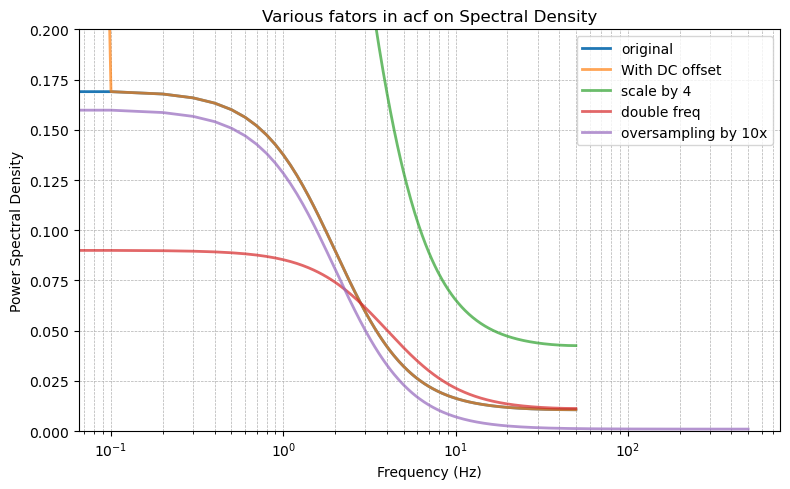

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create a test signal ---
np.random.seed(0)
t = np.linspace(0, 10, 1000)
t2= np.linspace(0,10,10000)
#signal = np.sin(2 * np.pi * 2 * t) + 0.5 * np.random.randn(len(t))  # oscillatory + noise
signal = np.exp(-2 * np.pi * 2 * t)
signal_with_offset = signal + 200.0  # constant offset
signal2=4*np.exp(-2 * np.pi * 2 * t)
signal3= np.exp(-2 * np.pi * 4 * t)
signal_oversampling= np.exp(-2 * np.pi * 2* t2)



# --- Compute spectral density via FFT ---
def spectral_density(x, dt):
    N = len(x)
    xf = np.fft.rfftfreq(N, d=dt)
    #psd = np.abs(np.fft.fft(x))**2 / N
    fft_result = np.fft.rfft(x, n=N, axis=0)

    # Real spectral density (normalized properly)
    J = 2 * dt * np.real(fft_result)
    return xf, J  # keep positive frequencies

dt = t[1] - t[0]
dt2= t2[1]-t2[0]
xf_no_offset, psd_no_offset = spectral_density(signal, dt)
xf_with_offset, psd_with_offset = spectral_density(signal_with_offset, dt)
xf_no_offset2, psd_no_offset2 = spectral_density(signal2, dt)
xf_no_offset3, psd_no_offset3 = spectral_density(signal3, dt)
xf_oversampling, psd_oversampling = spectral_density(signal_oversampling, dt2)

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(xf_no_offset, psd_no_offset, label='original', lw=2)
plt.plot(xf_with_offset, psd_with_offset, label='With DC offset', lw=2, alpha=0.7)
plt.plot(xf_no_offset2, psd_no_offset2,label='scale by 4', lw=2, alpha=0.7 )
plt.plot(xf_no_offset3, psd_no_offset3,label='double freq', lw=2, alpha=0.7 )
plt.plot(xf_oversampling, psd_oversampling, label='oversampling by 10x', lw=2, alpha=0.7)

plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.ylim(-0, 0.2)
plt.legend()
plt.title('Various fators in acf on Spectral Density')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()


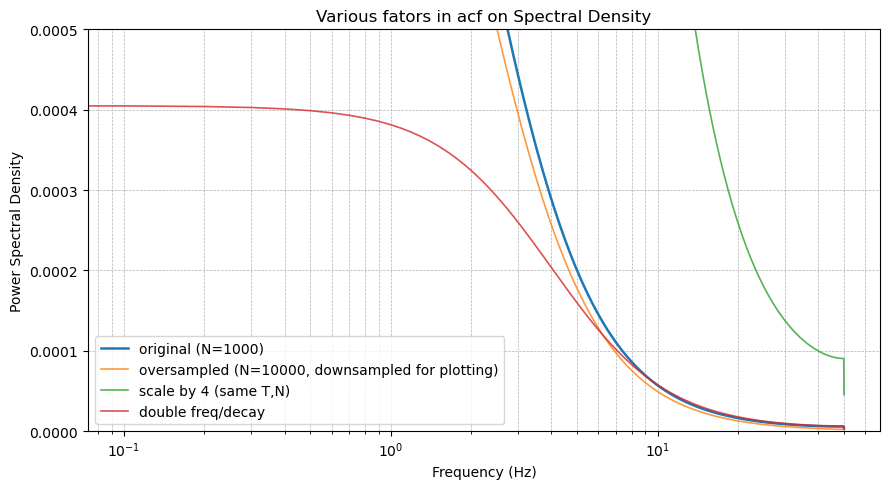

Peak ratio (oversampled / original) ≈ 0.8935732117766237


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- signals: same total duration T, different sampling rates ---
f_signal = 2.0  # Hz (exponential decay rate in your example)
T = 10.0        # total duration in seconds
N1 = 1000       # original number of samples
N2 = 10000      # oversampled number of samples (10x)

t  = np.linspace(0, T, N1, endpoint=False)
t2 = np.linspace(0, T, N2, endpoint=False)

signal      = np.exp(-2 * np.pi * 2 * t)        # original (no offset here)
signal_with_offset = signal + 200.0
signal2     = 4 * np.exp(-2 * np.pi * 2 * t)   # scaled by 4 (same T and N1)
signal3     = np.exp(-2 * np.pi * 4 * t)       # double frequency/decay
signal_oversampling = np.exp(-2 * np.pi * 2 * t2)  # same T, more samples

# --- Proper PSD function (one-sided) ---
def spectral_density_one_sided(x, dt):
    """
    Compute one-sided PSD from real signal x sampled with spacing dt.
    Returns positive frequencies xf and PSD S (same length as rfft result).
    """
    N = len(x)
    # remove mean if you are comparing shapes (prevents huge DC spike)
    x_zero_mean = x 

    # rfft
    fft_r = np.fft.rfft(x_zero_mean)
    # frequency axis
    xf = np.fft.rfftfreq(N, d=dt)

    # one-sided PSD normalization:
    # S = (2*dt / N) * |FFT|^2, with DC and Nyquist not doubled.
    S = (2.0 * dt / N) * (np.abs(fft_r) ** 2)

    # fix DC bin (do not double)
    S[0] = (dt / N) * (np.abs(fft_r[0]) ** 2)

    # If N is even, the last rfft bin is Nyquist and should not be doubled either
    if N % 2 == 0:
        S[-1] = (dt / N) * (np.abs(fft_r[-1]) ** 2)

    return xf, S

# --- compute dt values ---
dt  = t[1] - t[0]
dt2 = t2[1] - t2[0]

# --- compute PSDs ---
xf_no_offset,  psd_no_offset  = spectral_density_one_sided(signal, dt)
xf_with_offset, psd_with_offset = spectral_density_one_sided(signal_with_offset, dt)
xf_no_offset2, psd_no_offset2 = spectral_density_one_sided(signal2, dt)
xf_no_offset3, psd_no_offset3 = spectral_density_one_sided(signal3, dt)
xf_oversampling, psd_oversampling = spectral_density_one_sided(signal_oversampling, dt2)

# --- Plot ---
plt.figure(figsize=(9,5))
plt.plot(xf_no_offset,  psd_no_offset,      label='original (N=1000)', lw=1.8)
plt.plot(xf_oversampling[:len(psd_oversampling)//10], psd_oversampling[:len(psd_oversampling)//10],
         label='oversampled (N=10000, downsampled for plotting)', lw=1.2, alpha=0.8)
plt.plot(xf_no_offset2, psd_no_offset2, label='scale by 4 (same T,N)', lw=1.2, alpha=0.8)
plt.plot(xf_no_offset3, psd_no_offset3, label='double freq/decay', lw=1.2, alpha=0.8)

plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.ylim(-0, 0.0005)
plt.legend()
plt.title('Various fators in acf on Spectral Density')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# --- quick checks ---
# compare peak PSD values near the signal frequency (approx)
def peak_near(freq_axis, psd, f_target, tol=0.5):
    idx = np.where((freq_axis >= f_target - tol) & (freq_axis <= f_target + tol))[0]
    return np.max(psd[idx]) if idx.size else np.nan

p1 = peak_near(xf_no_offset, psd_no_offset, f_signal)
p_overs = peak_near(xf_oversampling, psd_oversampling, f_signal)
print("Peak ratio (oversampled / original) ≈", p_overs / p1)


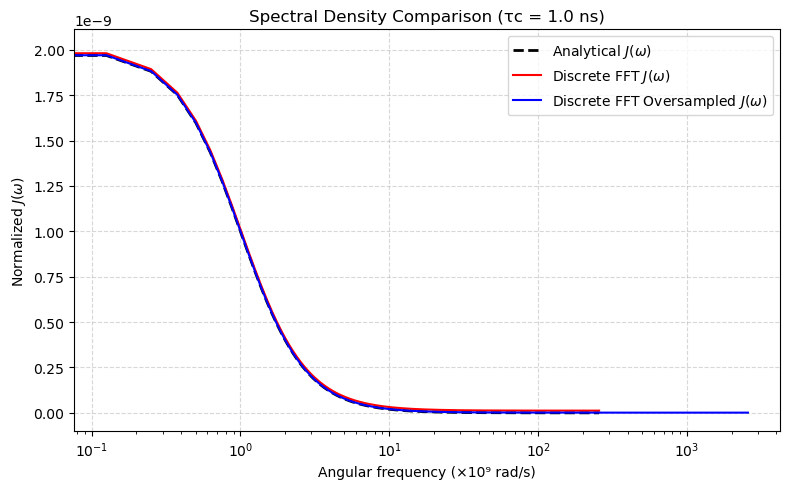

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
tau_c = 1e-9       # correlation time (s)
Tmax = 5e-8        # total correlation time window (50 ns)
N = 4096            # number of points (power of 2 for FFT efficiency)

# --- time axis ---
t = np.linspace(0, Tmax, N)
t2=np.linspace(0,Tmax,10*N)
dt = t[1] - t[0]
dt2=t2[1]-t2[0]
# --- correlation function (exponential decay) ---
C_t = np.exp(-t / tau_c)
C_t2= np.exp(-t2 / tau_c)

# --- discrete spectral density via FFT ---
fft_result = np.fft.rfft(C_t)
omega = 2 * np.pi * np.fft.rfftfreq(N, d=dt)  # angular frequency (rad/s)
J_discrete = 2 * dt * np.real(fft_result)     # correct scaling for even C(t)


fft_result2= np.fft.rfft(C_t2)
omega2= 2 * np.pi * np.fft.rfftfreq(10*N, d=dt2)
J_discrete2= 2* dt2* np.real(fft_result2)   

# --- analytical spectral density (isotropic global tumbling) ---
J_analytic = 2 * tau_c / (1 + (omega * tau_c)**2)

# optional normalization for comparison of shape only
# J_discrete /= J_discrete[0]
# J_analytic /= J_analytic[0]

# --- Plot comparison ---
plt.figure(figsize=(8,5))
plt.plot(omega*1e-9, J_analytic, 'k--', lw=2, label='Analytical $J(\\omega)$')
plt.plot(omega*1e-9, J_discrete, 'r-', lw=1.5, label='Discrete FFT $J(\\omega)$')
plt.plot(omega2*1e-9, J_discrete2, 'b-', lw=1.5, label='Discrete FFT Oversampled $J(\\omega)$')
plt.xlabel('Angular frequency (×10⁹ rad/s)')
plt.ylabel('Normalized $J(\\omega)$')
plt.title(f'Spectral Density Comparison (τc = {tau_c*1e9:.1f} ns)')
plt.legend()
plt.xscale('log')
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()
